In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
from pokerl.env.pokemonblue import PokemonBlueEnv

x = torch.rand( 1, 160, 144)

In [2]:
x = torchvision.transforms.Resize((128, 128)).forward(x.unsqueeze(0)).squeeze(0)

/Users/bpugnaire/Dev/github/pokeRL/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
x = torch.rand(160, 144)
x=x.float() 
x = x.unsqueeze(0)  # Add a channel dimension

normalizer = torchvision.transforms.Normalize(mean=[0], std=[1])
x = normalizer.forward(x)

In [5]:
x.shape

torch.Size([1, 160, 144])

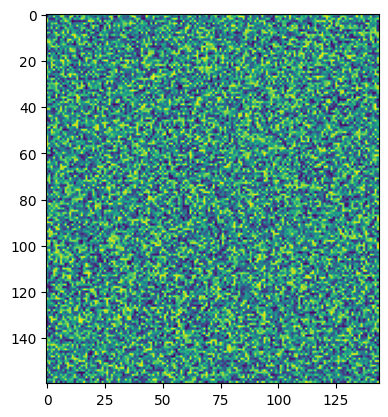

In [6]:
plt.imshow(x.permute(1, 2, 0)  )


In [27]:
grey_scaler= torchvision.transforms.Grayscale()
x  = grey_scaler.forward(x)
x = torchvision.transforms.Resize((160, 144)).forward(x)

In [28]:
x.shape

torch.Size([1, 160, 144])

In [29]:
from pokerl.agent.own_dreamer.nets.image_encoder import ImageEncoderResnet
ImageEncoderResnet(input_shape=x.shape)


ImageEncoderResnet(
  (_net): Sequential(
    (0): Conv2d(1, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ResidualBlock(
      (_conv1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_act1): SiLU()
      (_conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_act2): SiLU()
    )
    (2): ResidualBlock(
      (_conv1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_act1): SiLU()
      (_conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_act2): SiLU()
    )
    (3): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ResidualBlock(
      (_conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_act1): SiLU()
      (_conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_act2): SiLU()
    )
    (5): ResidualBlock(
      (_conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), paddi

In [30]:
ImageEncoderResnet(input_shape=x.shape).forward(x).shape


torch.Size([768, 20])

In [ ]:
from pokerl.agent.own_dreamer.nets.reference import ConvEncoder

encoder = ConvEncoder((128,128,1), depth=48)

In [ ]:
encoder.forward(x.reshape((1, 128, 128, 1))).shape

torch.Size([1, 48, 64, 64])
torch.Size([1, 96, 32, 32])
torch.Size([1, 192, 16, 16])
torch.Size([1, 384, 8, 8])
torch.Size([1, 768, 4, 4])


torch.Size([1, 12288])

In [ ]:
input_size = 129
kernel_size = 4
stride = 2
padding = 0
print((input_size - kernel_size + 2*padding) / stride + 1)

63.5
